In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import os
from tqdm.notebook import tqdm
import evaluate
import torch.nn as nn
sns.set_context('paper')
sns.set_style('ticks')

In [2]:
df = pd.read_csv('taylorswiftspotify.csv',encoding='latin1')
df.head()

,album_name,album_release,track_number,track_name,genre1,genre2,artist,featuring,rating,writing,...,liveness,valence,tempo,time_signature,duration_ms,explicit,key_name,mode_name,key_mode,lyrics
0,Taylor Swift,2006-10-24,1,Tim McGraw,Country,NaN,Taylor Swift,NaN,clean,co-written,...,0.1210,0.694203,76.009,4,232107,False,C,major,C major,He said the way my blue eyes shined \.\ Put th...
1,Taylor Swift,2006-10-24,2,Picture To Burn,Country,Rock,Taylor Swift,NaN,clean,self-written,...,0.0962,0.678604,105.586,4,173067,False,G,major,G major,"State the obvious, I didn't get my perfect fan..."
2,Taylor Swift,2006-10-24,3,Teardrops On My Guitar,Country,Pop,Taylor Swift,NaN,clean,co-written,...,0.1190,0.516663,99.953,4,203040,False,A#,major,A# major,Drew looks at me \.\ I fake a smile so he won'...
3,Taylor Swift,2006-10-24,4,A Place In This World,Country,Pop,Taylor Swift,NaN,clean,co-written,...,0.3200,0.609739,115.028,4,199200,False,A,major,A major,"I don't know what I want, so don't ask me \.\ ..."
4,Taylor Swift,2006-10-24,5,Cold As You,Country,NaN,Taylor Swift,NaN,clean,self-written,...,0.1230,0.591097,175.558,4,239013,False,F,major,F major,You have a way of coming easily to me \.\ And ...


In [3]:
df.isna().sum()

album_name              0
album_release           0
track_number            0
track_name              0
genre1                  0
genre2                 49
artist                  0
featuring             146
rating                  0
writing                 0
bonus_track             0
promotional_single      0
single                  0
streams                 0
danceability            0
energy                  0
key                     0
loudness                0
mode                    0
speechiness             0
acousticness            0
instrumentalness        0
liveness                0
valence                 0
tempo                   0
time_signature          0
duration_ms             0
explicit                0
key_name                0
mode_name               0
key_mode                0
lyrics                  0
dtype: int64

In [4]:
df.columns

Index(['album_name', 'album_release', 'track_number', 'track_name', 'genre1',
       'genre2', 'artist', 'featuring', 'rating', 'writing', 'bonus_track',
       'promotional_single', 'single', 'streams', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'duration_ms', 'explicit', 'key_name', 'mode_name', 'key_mode',
       'lyrics'],
      dtype='object')

In [5]:
df['genre1'].value_counts()

genre1
Pop            71
Country        51
Alternative    34
Name: count, dtype: int64

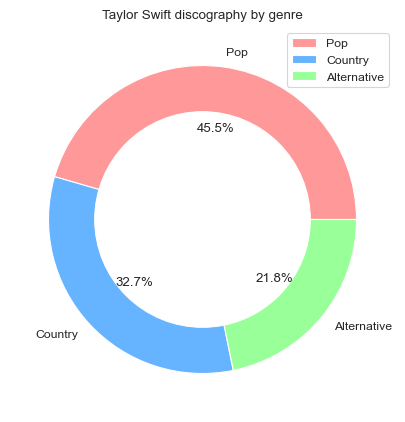

In [6]:
fig = plt.figure(figsize=(10,5))
plt.pie(df['genre1'].value_counts(),labels=df['genre1'].value_counts().index,autopct='%1.1f%%',colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6','#ff6666'])
my_circle = plt.Circle( (0,0), 0.7, color='white')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.legend()
plt.title(f'Taylor Swift discography by genre')
plt.show();

From the donut chart, we can see that 45.5% of Swift's discography is made up of pop songs, 21.8% is alternative, 32.7% is country

In [7]:
df['writing'].value_counts()

writing
co-written      103
self-written     53
Name: count, dtype: int64

In [8]:
#draw a sankey diagram between genre, album, rating, and writing
from pySankey.sankey import sankey
import plotly.graph_objects as go
import plotly.express as px

In [9]:
df['album_name'].value_counts()

album_name
Red             22
Fearless        19
Lover           18
Speak Now       17
Folklore        17
Evermore        17
1989            16
Taylor Swift    15
Reputation      15
Name: count, dtype: int64

In [10]:
df['rating'].value_counts()

rating
clean       144
explicit     12
Name: count, dtype: int64

In [11]:
#create a dataframe with the columns we want
df_sankey = df[['genre1','album_name','rating','writing']]
df_sankey.head()

,genre1,album_name,rating,writing
0,Country,Taylor Swift,clean,co-written
1,Country,Taylor Swift,clean,self-written
2,Country,Taylor Swift,clean,co-written
3,Country,Taylor Swift,clean,co-written
4,Country,Taylor Swift,clean,self-written


In [12]:
from pysankey2 import Sankey

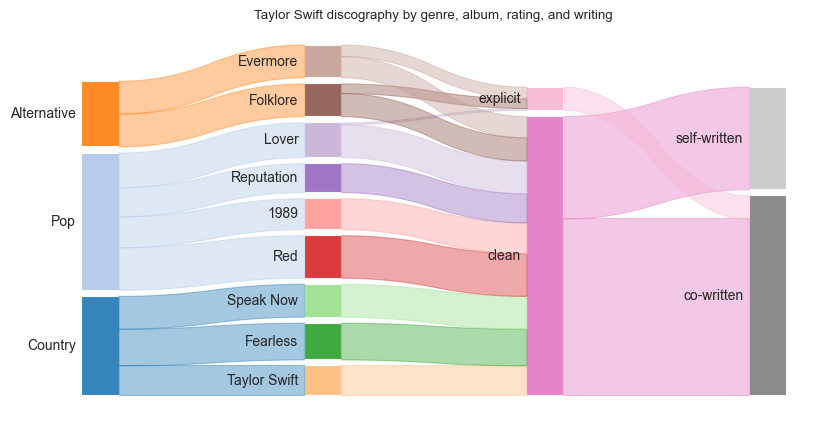

In [13]:
auto_color = Sankey(df_sankey,colorMode='layer',stripColor='left')
fig,ax = auto_color.plot(figSize=(10,5))
ax.set_title('Taylor Swift discography by genre, album, rating, and writing')
plt.show();

In [14]:
#spotify features -correlation matrix danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,tempo,valence
num_features = ['danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness','tempo','valence']

In [15]:
corr_matrix = df[num_features].corr('spearman')
corr_matrix

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,tempo,valence
danceability,1.000000,0.067171,-0.004414,-0.587301,-0.131634,-0.530054,-0.034705,-0.218695,0.745266
energy,0.067171,1.000000,0.650706,0.022121,-0.564259,0.072792,0.015016,0.130573,-0.051534
loudness,-0.004414,0.650706,1.000000,0.057870,-0.681449,0.022954,0.201738,0.189220,-0.000082
speechiness,-0.587301,0.022121,0.057870,1.000000,0.029197,0.287516,-0.026197,0.144836,-0.520852
acousticness,-0.131634,-0.564259,-0.681449,0.029197,1.000000,0.069568,-0.038868,-0.082179,-0.129872
instrumentalness,-0.530054,0.072792,0.022954,0.287516,0.069568,1.000000,-0.071348,0.050696,-0.475782
liveness,-0.034705,0.015016,0.201738,-0.026197,-0.038868,-0.071348,1.000000,0.110537,-0.026029
tempo,-0.218695,0.130573,0.189220,0.144836,-0.082179,0.050696,0.110537,1.000000,-0.195682
valence,0.745266,-0.051534,-0.000082,-0.520852,-0.129872,-0.475782,-0.026029,-0.195682,1.000000


<Axes: >

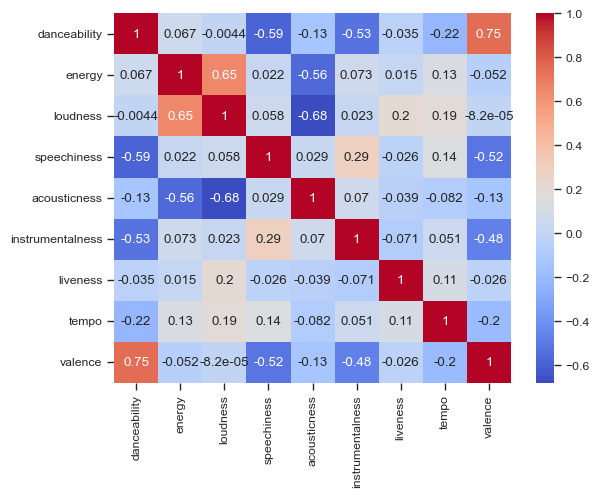

In [16]:
sns.heatmap(corr_matrix,annot=True,cmap='coolwarm')

From the heatmap, the positive correlations that stand out the most are those between:

- energy and loudness.
- danceability and valence.

Negative correlations that stand out the most are those between:
- energy and acousticness.
- danceability and speechiness.

<Figure size 800x300 with 0 Axes>

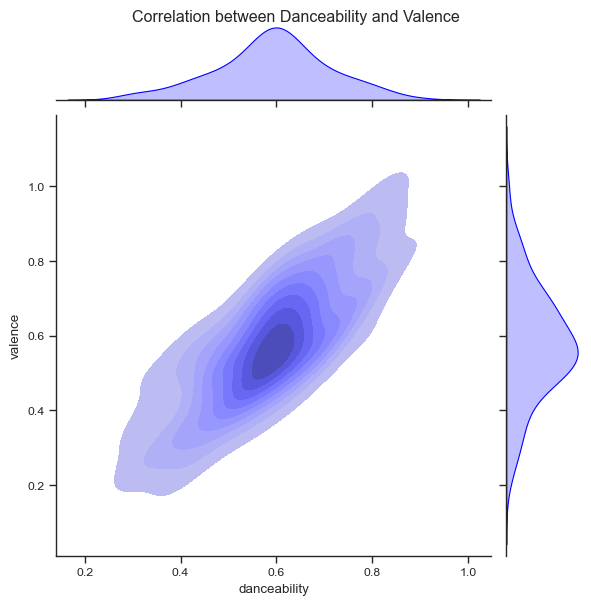

In [17]:
#all postive correlations
#2d kernel density plot
fig = plt.figure(figsize=(8,3))
p = sns.jointplot(data=df,x='danceability',y='valence',kind='kde',fill=True,color='Blue')
plt.suptitle('Correlation between Danceability and Valence',y=1)
plt.show();

<Figure size 800x300 with 0 Axes>

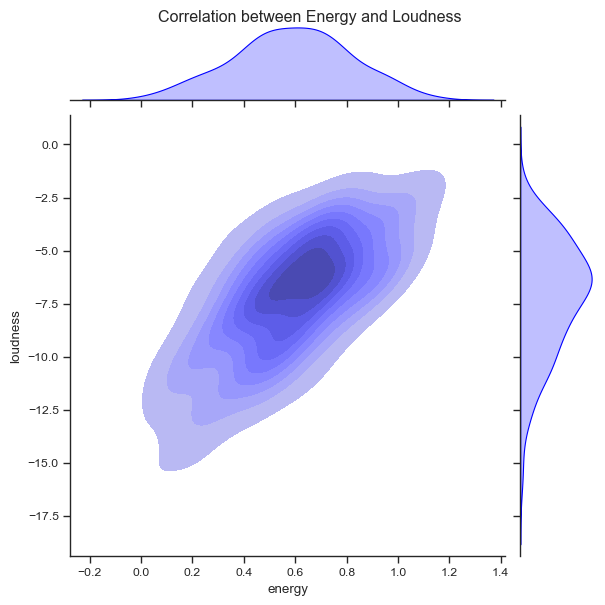

In [18]:
#all postive correlations
#2d kernel density plot
fig = plt.figure(figsize=(8,3))
p = sns.jointplot(data=df,x='energy',y='loudness',kind='kde',fill=True,color='Blue')
plt.suptitle('Correlation between Energy and Loudness',y=1)
plt.show();

In [19]:
##PCA
from sklearn.decomposition import PCA

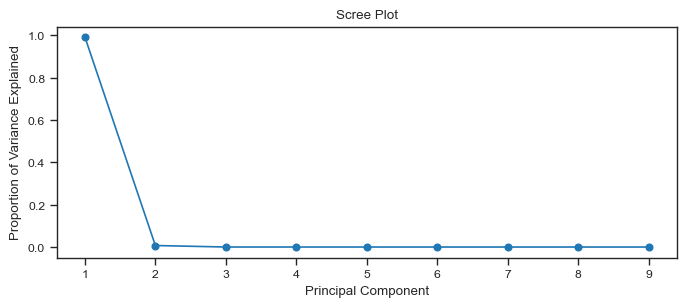

In [20]:
#scree plot
pca = PCA()
pca.fit(df[num_features])
pca_variance = pca.explained_variance_ratio_

fig = plt.figure(figsize=(8,3))
plt.plot(range(1,len(pca_variance)+1),pca_variance,'o-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show();

In [21]:
df2 = df.copy()    

In [22]:
import nltk

In [23]:
lyrics_df = df2[['track_name','album_name','lyrics']]

In [24]:
lyrics_df

,track_name,album_name,lyrics
0,Tim McGraw,Taylor Swift,He said the way my blue eyes shined \.\ Put th...
1,Picture To Burn,Taylor Swift,"State the obvious, I didn't get my perfect fan..."
2,Teardrops On My Guitar,Taylor Swift,Drew looks at me \.\ I fake a smile so he won'...
3,A Place In This World,Taylor Swift,"I don't know what I want, so don't ask me \.\ ..."
4,Cold As You,Taylor Swift,You have a way of coming easily to me \.\ And ...
...,...,...,...
151,marjorie,Evermore,Never be so kind \.\ You forget to be clever \...
152,closure,Evermore,It's been a long time \.\ And seeing the shape...
153,evermore,Evermore,Gray November \.\ I've been down since July \....
154,right where you left me,Evermore,"Friends break up, friends get married \.\ Stra..."


In [25]:
lyrics_df.isna().sum()

track_name    0
album_name    0
lyrics        0
dtype: int64

In [26]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BiswanathSaha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
#remove punctuation and special characters from the lyrics
import string
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]','',text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation),'',text)
    text = re.sub(r'\w*\d\w*','',text)
    return text

lyrics_df['lyrics'] = lyrics_df['lyrics'].apply(lambda x: clean_text(x))

#lyrics_df['lyrics']

C:\Users\BiswanathSaha\AppData\Local\Temp\ipykernel_21488\2507432863.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lyrics_df['lyrics'] = lyrics_df['lyrics'].apply(lambda x: clean_text(x))


In [28]:
lyrics_df.head()

,track_name,album_name,lyrics
0,Tim McGraw,Taylor Swift,he said the way my blue eyes shined put those...
1,Picture To Burn,Taylor Swift,state the obvious i didnt get my perfect fanta...
2,Teardrops On My Guitar,Taylor Swift,drew looks at me i fake a smile so he wont se...
3,A Place In This World,Taylor Swift,i dont know what i want so dont ask me cause ...
4,Cold As You,Taylor Swift,you have a way of coming easily to me and whe...


In [29]:
#calcuate tokens per song
lyrics_df['tokens'] = lyrics_df['lyrics'].apply(lambda x: len(nltk.word_tokenize(x)))

C:\Users\BiswanathSaha\AppData\Local\Temp\ipykernel_21488\184467458.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lyrics_df['tokens'] = lyrics_df['lyrics'].apply(lambda x: len(nltk.word_tokenize(x)))


In [30]:
lyrics_df.head()

,track_name,album_name,lyrics,tokens
0,Tim McGraw,Taylor Swift,he said the way my blue eyes shined put those...,366
1,Picture To Burn,Taylor Swift,state the obvious i didnt get my perfect fanta...,292
2,Teardrops On My Guitar,Taylor Swift,drew looks at me i fake a smile so he wont se...,288
3,A Place In This World,Taylor Swift,i dont know what i want so dont ask me cause ...,232
4,Cold As You,Taylor Swift,you have a way of coming easily to me and whe...,245


C:\Users\BiswanathSaha\AppData\Local\Temp\ipykernel_21488\2326160323.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(lyrics_df['tokens'],shade=True)


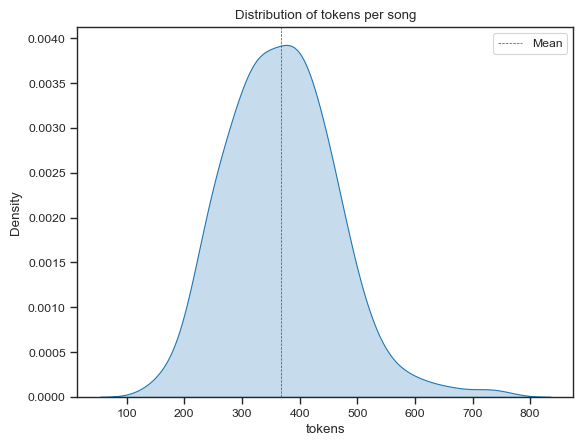

In [31]:
sns.kdeplot(lyrics_df['tokens'],shade=True)
plt.title('Distribution of tokens per song')
plt.axvline(lyrics_df['tokens'].mean(),color='red',label='Mean',linestyle='--',linewidth=0.5)
plt.legend()
plt.show();

In [32]:
df.columns

Index(['album_name', 'album_release', 'track_number', 'track_name', 'genre1',
       'genre2', 'artist', 'featuring', 'rating', 'writing', 'bonus_track',
       'promotional_single', 'single', 'streams', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'duration_ms', 'explicit', 'key_name', 'mode_name', 'key_mode',
       'lyrics'],
      dtype='object')

In [33]:
df['album_release'].value_counts()
df['album_year'] = pd.DatetimeIndex(df['album_release']).year

In [34]:
lyrics_df['album_year'] = df['album_year']

C:\Users\BiswanathSaha\AppData\Local\Temp\ipykernel_21488\3311542060.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lyrics_df['album_year'] = df['album_year']


In [35]:
lyrics_df.head()

,track_name,album_name,lyrics,tokens,album_year
0,Tim McGraw,Taylor Swift,he said the way my blue eyes shined put those...,366,2006
1,Picture To Burn,Taylor Swift,state the obvious i didnt get my perfect fanta...,292,2006
2,Teardrops On My Guitar,Taylor Swift,drew looks at me i fake a smile so he wont se...,288,2006
3,A Place In This World,Taylor Swift,i dont know what i want so dont ask me cause ...,232,2006
4,Cold As You,Taylor Swift,you have a way of coming easily to me and whe...,245,2006


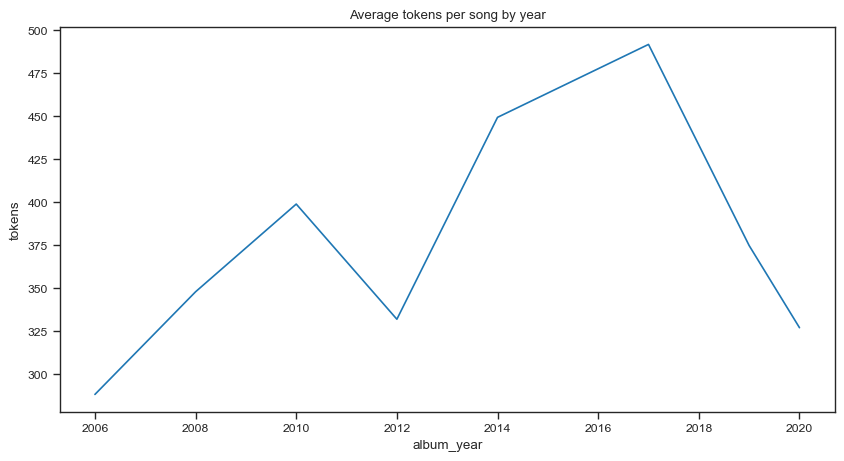

In [36]:
#average tokens per song by year
lyrics_df.groupby('album_year')['tokens'].mean()

fig = plt.figure(figsize=(10,5))
sns.lineplot(data=lyrics_df,x='album_year',y='tokens',errorbar=None,markers='o')
plt.title('Average tokens per song by year')
plt.show();

In [37]:
#calculate lexical diversity
def lexical_diversity(text):
    return len(set(text)) / len(text)

lyrics_df['lexical_diversity'] = lyrics_df['lyrics'].apply(lambda x: lexical_diversity(nltk.word_tokenize(x)))

lyrics_df.head()

C:\Users\BiswanathSaha\AppData\Local\Temp\ipykernel_21488\3153670334.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lyrics_df['lexical_diversity'] = lyrics_df['lyrics'].apply(lambda x: lexical_diversity(nltk.word_tokenize(x)))


,track_name,album_name,lyrics,tokens,album_year,lexical_diversity
0,Tim McGraw,Taylor Swift,he said the way my blue eyes shined put those...,366,2006,0.333333
1,Picture To Burn,Taylor Swift,state the obvious i didnt get my perfect fanta...,292,2006,0.376712
2,Teardrops On My Guitar,Taylor Swift,drew looks at me i fake a smile so he wont se...,288,2006,0.447917
3,A Place In This World,Taylor Swift,i dont know what i want so dont ask me cause ...,232,2006,0.353448
4,Cold As You,Taylor Swift,you have a way of coming easily to me and whe...,245,2006,0.416327


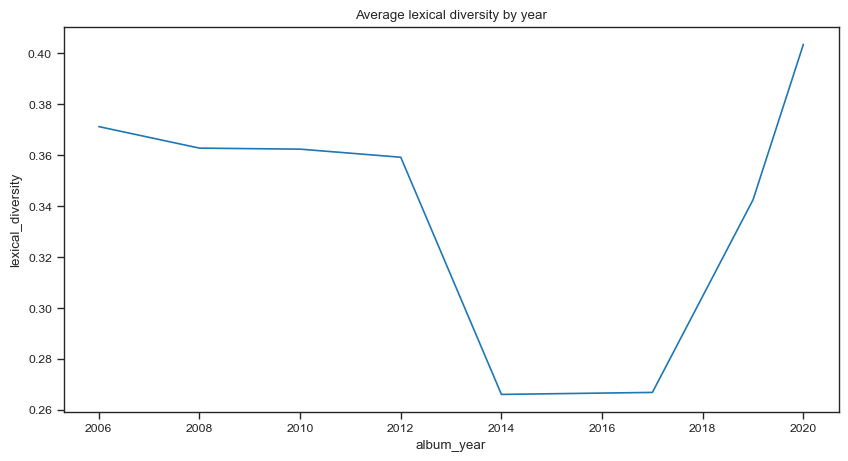

In [38]:
#average lexical diversity token ratio by year
lyrics_df.groupby('album_year')['lexical_diversity'].mean()

fig = plt.figure(figsize=(10,5))
sns.lineplot(data=lyrics_df,x='album_year',y='lexical_diversity',errorbar=None,markers='o')
plt.title('Average lexical diversity by year')
plt.show();

In [39]:
import wordcloud

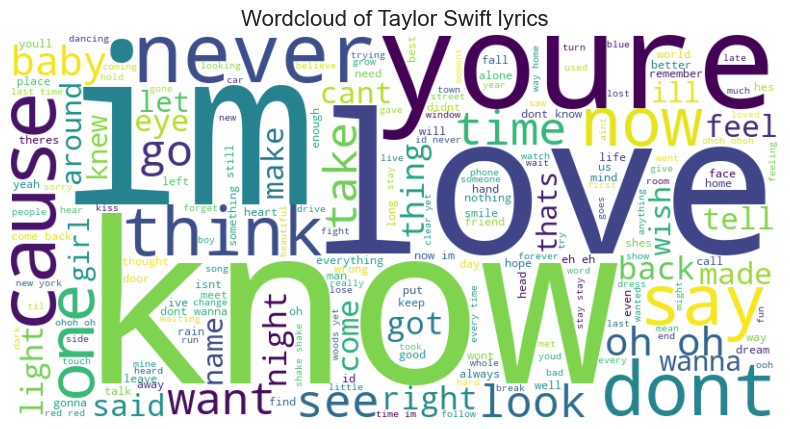

In [40]:
#wordcloud
from wordcloud import WordCloud
from PIL import Image
from wordcloud import STOPWORDS

text = " ".join(lyrics_df['lyrics'])

wordcloud = WordCloud(width=800,height=400,background_color='white',stopwords=STOPWORDS).generate(text)

fig = plt.figure(figsize=(10,5))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud of Taylor Swift lyrics',fontsize=16)
plt.show();

In [41]:
## Data modelling for google Gemma - Lyrics generator

In [42]:
#create a dictionary of lyrics
lyrics_raw = lyrics_df['lyrics'].to_list()
print(len(lyrics_raw))

156


In [43]:
from datasets import Dataset

In [44]:
lyrics_dataset = Dataset.from_pandas(lyrics_df)

In [45]:
lyrics_dataset

Dataset({
    features: ['track_name', 'album_name', 'lyrics', 'tokens', 'album_year', 'lexical_diversity'],
    num_rows: 156
})

In [46]:
lyrics_dataset[0]

{'track_name': 'Tim McGraw',
 'album_name': 'Taylor Swift',
 'lyrics': 'he said the way my blue eyes shined  put those georgia stars to shame that night  i said thats a lie  just a boy in a chevy truck  that had a tendency of gettin stuck  on backroads at night  and i was right there beside him all summer long  and then the time we woke up to find that summer gone  but when you think tim mcgraw  i hope you think my favorite song  the one we danced to all night long  the moon like a spotlight on the lake  when you think happiness  i hope you think that little black dress  think of my head on your chest  and my old faded blue jeans  when you think tim mcgraw  i hope you think of me  september saw a month of tears  and thankin god that you werent here  to see me like that  but in a box beneath my bed  is a letter that you never read  from three summers back  its hard not to find it all a little bittersweet  and lookin back on all of that its nice to believe  when you think tim mcgraw  i h

In [47]:
#rename the lyrics column to text
lyrics_dataset = lyrics_dataset.rename_column('lyrics','text')

lyrics_dataset[0]

{'track_name': 'Tim McGraw',
 'album_name': 'Taylor Swift',
 'text': 'he said the way my blue eyes shined  put those georgia stars to shame that night  i said thats a lie  just a boy in a chevy truck  that had a tendency of gettin stuck  on backroads at night  and i was right there beside him all summer long  and then the time we woke up to find that summer gone  but when you think tim mcgraw  i hope you think my favorite song  the one we danced to all night long  the moon like a spotlight on the lake  when you think happiness  i hope you think that little black dress  think of my head on your chest  and my old faded blue jeans  when you think tim mcgraw  i hope you think of me  september saw a month of tears  and thankin god that you werent here  to see me like that  but in a box beneath my bed  is a letter that you never read  from three summers back  its hard not to find it all a little bittersweet  and lookin back on all of that its nice to believe  when you think tim mcgraw  i hop

In [48]:
lyrics_df.to_csv('lyrics.csv',index=False)